In [1]:
import os
import pandas as pd

In [2]:
mypath = 'Citra_BISINDO/'

In [3]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [4]:
# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
# df = pd.DataFrame({"path":full_path,'file_name':file_name})
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
      1
O    12
S    12
dtype: int64

In [5]:
#cek sample datanya
df.head()

,path,file_name,tag
0,Citra_BISINDO/.DS_Store,.DS_Store,
1,Citra_BISINDO/S/body white (4).jpg,body white (4).jpg,S
2,Citra_BISINDO/S/wall white (4).jpg,wall white (4).jpg,S
3,Citra_BISINDO/S/body white (2).jpg,body white (2).jpg,S
4,Citra_BISINDO/S/wall white (3).jpg,wall white (3).jpg,S


In [7]:
import cv2

# check image shape-nya
img = cv2.imread('Citra_BISINDO/S/body white (4).jpg')
print(type(img))
# <class 'numpy.ndarray'>

print(img.shape)
# (788, 789, 3)

<class 'numpy.ndarray'>
(819, 820, 3)


In [8]:
s = df.loc[df['tag'] == 'S']
s.head()

,path,file_name,tag
1,Citra_BISINDO/S/body white (4).jpg,body white (4).jpg,S
2,Citra_BISINDO/S/wall white (4).jpg,wall white (4).jpg,S
3,Citra_BISINDO/S/body white (2).jpg,body white (2).jpg,S
4,Citra_BISINDO/S/wall white (3).jpg,wall white (3).jpg,S
5,Citra_BISINDO/S/wall white (2).jpg,wall white (2).jpg,S


In [9]:
o = df.loc[df['tag'] == 'O']
o.head()

,path,file_name,tag
13,Citra_BISINDO/O/body white (4).jpg,body white (4).jpg,O
14,Citra_BISINDO/O/wall white (4).jpg,wall white (4).jpg,O
15,Citra_BISINDO/O/body white (2).jpg,body white (2).jpg,O
16,Citra_BISINDO/O/wall white (3).jpg,wall white (3).jpg,O
17,Citra_BISINDO/O/wall white (2).jpg,wall white (2).jpg,O


In [10]:
df = pd.concat([s, o], ignore_index=True)
df.head()

,path,file_name,tag
0,Citra_BISINDO/S/body white (4).jpg,body white (4).jpg,S
1,Citra_BISINDO/S/wall white (4).jpg,wall white (4).jpg,S
2,Citra_BISINDO/S/body white (2).jpg,body white (2).jpg,S
3,Citra_BISINDO/S/wall white (3).jpg,wall white (3).jpg,S
4,Citra_BISINDO/S/wall white (2).jpg,wall white (2).jpg,S


In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
import tensorflow as tf
from tensorflow import keras

train_ds = tf.keras.utils.image_dataset_from_directory(
  mypath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24 files belonging to 2 classes.
Using 20 files for training.


2022-07-11 08:59:01.827606: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  mypath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24 files belonging to 2 classes.
Using 4 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['O', 'S']


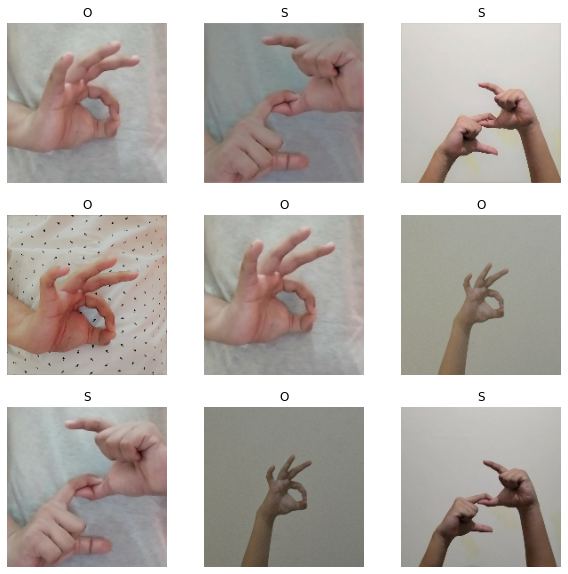

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 180, 180, 3)
(20,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

In [19]:
import numpy as np

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.06910168 0.8071683


In [20]:
from tensorflow.keras.models import Sequential

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [23]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1/1 [==============================] - 1s 977ms/step - loss: 0.6837 - accuracy: 0.7500 - val_loss: 0.5433 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 214ms/step - loss: 0.5597 - accuracy: 1.0000 - val_loss: 2.1879 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 215ms/step - loss: 2.3831 - accuracy: 0.5000 - val_loss: 0.4945 - val_accuracy: 0.7500
Epoch 4/10
1/1 [==============================] - 0s 211ms/step - loss: 0.5217 - accuracy: 0.6500 - val_loss: 0.6136 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 187ms/step - loss: 0.6613 - accuracy: 0.5000 - val_loss: 0.4354 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 216ms/step - loss: 0.4590 - accuracy: 1.0000 - val_loss: 0.5075 - val_accuracy: 0.7500
Epoch 7/10
1/1 [==============================] - 0s 221ms/step - loss: 0.5420 - accuracy: 0.6500 - val_loss: 0.4333 - val_accuracy: 1.0000
Epoch 8/10
1/1 [====

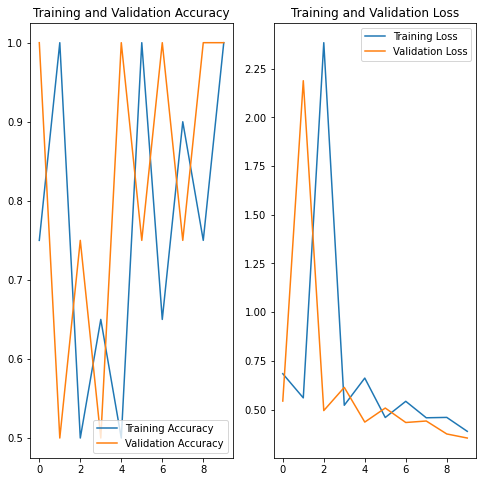

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

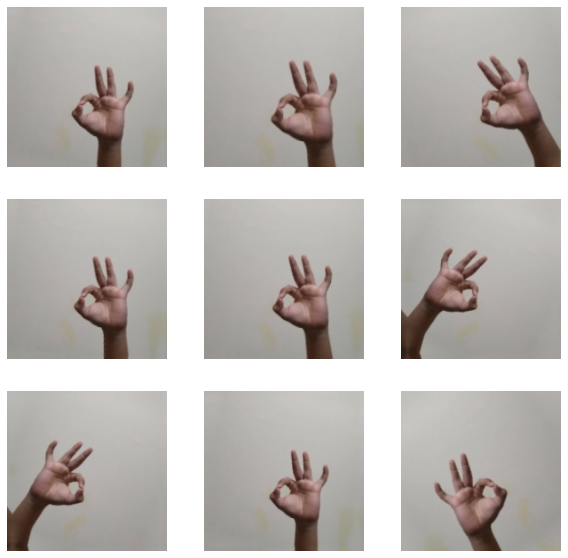

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
1/1 [==============================] - 1s 968ms/step - loss: 0.6778 - accuracy: 0.6000 - val_loss: 2.0068 - val_accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 0s 247ms/step - loss: 2.1555 - accuracy: 0.5000 - val_loss: 2.6741 - val_accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 0s 231ms/step - loss: 2.7733 - accuracy: 0.5000 - val_loss: 1.7437 - val_accuracy: 0.5000
Epoch 4/15
1/1 [==============================] - 0s 239ms/step - loss: 1.8254 - accuracy: 0.5000 - val_loss: 0.7602 - val_accuracy: 0.5000
Epoch 5/15
1/1 [==============================] - 0s 242ms/step - loss: 0.7532 - accuracy: 0.5000 - val_loss: 0.7405 - val_accuracy: 0.5000
Epoch 6/15
1/1 [==============================] - 0s 250ms/step - loss: 0.7662 - accuracy: 0.5000 - val_loss: 0.8683 - val_accuracy: 0.5000
Epoch 7/15
1/1 [==============================] - 0s 243ms/step - loss: 0.9038 - accuracy: 0.5000 - val_loss: 0.8547 - val_accuracy: 0.5000
Epoch 8/15
1/1 [====

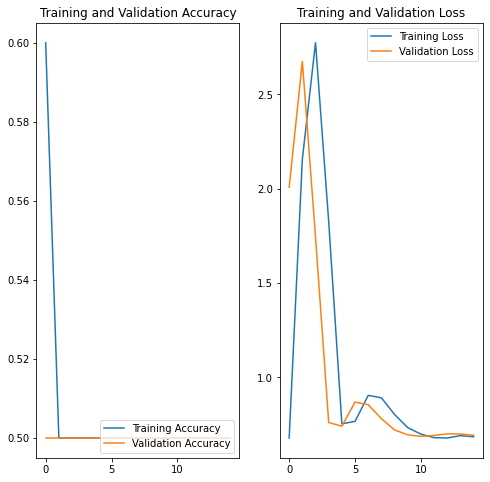

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
dirpath = 'Citra_BISINDO/S/body white (4).jpg'

img = tf.keras.utils.load_img(
    dirpath, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to S with a 54.18 percent confidence.
